In [ ]:
gpu=7
CUDA_VISIBLE_DEVICES=gpu
!nvidia-smi

In [2]:
import numpy as np
import pandas as pd

# import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

# import osa
import shutil

In [3]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
# import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = gpu

True
11721506816
0


In [5]:
df=pd.read_csv("/DATA/dataset/vinbig/vinbig/vinbigall_main_19k.csv")
df=df.sample(frac=1,random_state=172)

In [6]:
df.head()

,Unnamed: 0,path,target
9934,9934,trainpng/292ae3caa762e523cbdc2df76b2630bd.png,0.0
4011,4011,trainpng/b22bd21cfb3258bad7d934f036c34b5b.png,1.0
12428,12428,trainpng/27e57b4e9f14817c50b0bec64385e17f.png,0.0
5353,5353,trainpng/f25198406a72bdd912befbfa8fac68c7.png,0.0
9170,9170,trainpng/5f009092caee3729873a324a96749949.png,0.0


In [9]:
# df.iloc[0]

In [7]:
df=df.drop(columns=['Unnamed: 0'])

In [8]:
df["target"].value_counts()

1.0    10985
0.0    10606
Name: target, dtype: int64

In [10]:
df.shape

(21591, 2)

<AxesSubplot:xlabel='target', ylabel='count'>

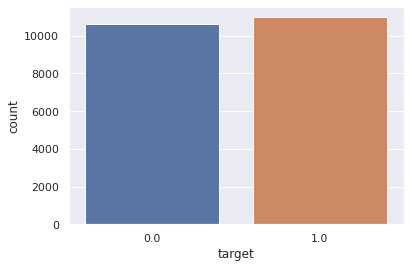

In [9]:
#Countplot
sns.set_theme(style="darkgrid")
sns.countplot(x="target", data=df.iloc[:])

<AxesSubplot:xlabel='target', ylabel='count'>

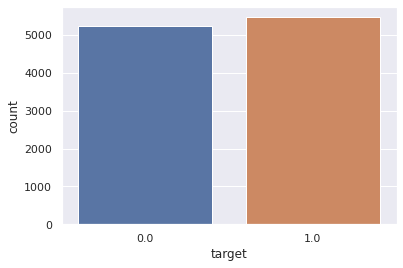

In [11]:
sns.set_theme(style="darkgrid")
sns.countplot(x="target", data=df.iloc[:10700])

<AxesSubplot:xlabel='target', ylabel='count'>

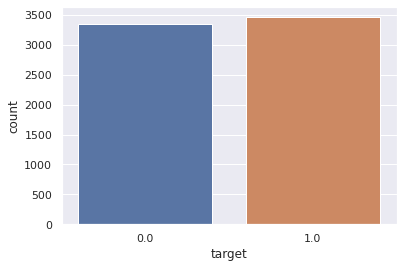

In [12]:
sns.set_theme(style="darkgrid")
sns.countplot(x="target", data=df.iloc[10700:17500])

<AxesSubplot:xlabel='target', ylabel='count'>

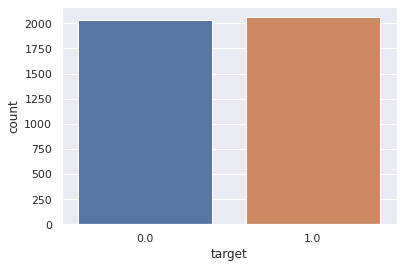

In [13]:
sns.set_theme(style="darkgrid")
sns.countplot(x="target", data=df.iloc[17500:])

In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform,start,count):
        self.ipaths = df["path"][start:count].to_numpy()
        self.target=df["target"][start:count].to_numpy()
        self.transform = transform
        self.count=count
        self.img_dir=img_dir


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img_path=self.img_dir+self.ipaths[idx]
        image = Image.open(img_path).convert('RGB')
        label=self.target[idx]
        image = self.transform(image)
        return image,label

In [8]:
normalizer=[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
transformations = {
		'train': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.RandomHorizontalFlip(),
			transforms.ColorJitter(brightness=0.25, contrast=0.25),
			transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'val': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'test': transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
		transforms.Normalize(normalizer[0], normalizer[1])])	
			}


In [16]:
df.shape

(21591, 2)

In [53]:
df['path'][0]
# /DATA/dataset/vinbig/vinbig/trainpng/0a0ac65c40a9ac441651e4bfbde03c4e.png

'50a418190bc3fb1ef1633bf9678929b3.png'

In [17]:
df.head()

,path,target
9934,trainpng/292ae3caa762e523cbdc2df76b2630bd.png,0.0
4011,trainpng/b22bd21cfb3258bad7d934f036c34b5b.png,1.0
12428,trainpng/27e57b4e9f14817c50b0bec64385e17f.png,0.0
5353,trainpng/f25198406a72bdd912befbfa8fac68c7.png,0.0
9170,trainpng/5f009092caee3729873a324a96749949.png,0.0


In [20]:
tr=int(0.6 * df.shape[0])
va=int(0.25*df.shape[0])+tr
tr,va

(12954, 18351)

In [33]:
# 0.60, 0.25,0.15
img_dir='/DATA/dataset/vinbig/vinbig/'
train_data=CustomImageDataset(df,img_dir,transformations["train"],0,tr)
valid_data=CustomImageDataset(df,img_dir,transformations["val"],tr,va)
test_data=CustomImageDataset(df,img_dir,transformations["test"],va,df.shape[0])
print(len(train_data))
print(len(test_data))
trainloader=torch.utils.data.DataLoader(train_data, batch_size=64)
valloader=torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader=torch.utils.data.DataLoader(test_data, batch_size=64)
print(trainloader)
print(len(testloader))
dataloaders = {"train":trainloader, "val":valloader, "test": testloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val','test']}
data_sizes

12954
3240
51


{'train': 12954, 'val': 5397, 'test': 3240}

In [4]:
import torch
torch.cuda.empty_cache()
device=torch.device("cuda:7")
print("Training on GPU... Ready for HyperJump...")

Training on GPU... Ready for HyperJump...


In [5]:
torch.cuda.set_device(gpu)

In [7]:
def densenet_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, 1) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = densenet_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.BCEWithLogitsLoss(reduction='mean').cuda()

# Specify optimizer which performs Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.0001, momentum=0.9)		

# Learning Scheduler
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience = 5)



In [26]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6954881


In [34]:
from sklearn.metrics import roc_auc_score
def epoch_train(model,optimizer, criterion):
    model.train()
    loss_train = 0
    loss_train_norm = 0
    loss_tensor_mean_train = 0
    output_list = []
    label_list = []
    phase="train"
    for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
        inputs = inputs.to(device, non_blocking=True)
        # labels = labels.type(torch.FloatTensor) 
        labels = labels.to(device, non_blocking=True)
        labels = labels.view(labels.size()[0],-1)

        optimizer.zero_grad()			
        outputs = model(inputs)
        # _, preds = torch.max(outputs.data, 1)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
            score = torch.sigmoid(outputs)
        else:
            score = torch.sigmoid(outputs)
        preds = score>0.5
        preds = preds.type(torch.cuda.LongTensor)
        
        labels = labels.type(torch.cuda.FloatTensor) #add for BCE loss
        loss = criterion(outputs, labels)
        loss_tensor_mean_train += loss

        labels = labels.data.cpu().numpy()
        outputs = outputs.data.cpu().numpy()

        for i in range(outputs.shape[0]):
            output_list.append(outputs[i].tolist())
            label_list.append(labels[i].tolist())

        loss_train_norm += 1
        loss.backward()
        optimizer.step()
    loss_tensor_mean_train = np.float(loss_tensor_mean_train) / loss_train_norm
    epoch_auc =  roc_auc_score(np.array(label_list), np.array(output_list))
    output_list = []
    label_list = []
    return loss_tensor_mean_train, epoch_auc



In [35]:
def epoch_val(model, criterion):
    model.eval()
    loss_val = 0
    loss_val_norm = 0
    loss_tensor_mean_val = 0
    # running_corrects = 0
    output_list = []
    label_list = []
    phase='val'
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
            labels = labels.type(torch.FloatTensor) #add for BCE loss
            inputs = inputs.cuda(gpu_id, non_blocking=True)
            labels = labels.cuda(gpu_id, non_blocking=True)
            labels = labels.view(labels.size()[0],-1) #add for BCE loss

            outputs = model(inputs)
            loss_tensor = criterion(outputs, labels)
            loss_tensor_mean_val += loss_tensor
            
            labels = labels.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()

            for i in range(outputs.shape[0]):
                output_list.append(outputs[i].tolist())
                label_list.append(labels[i].tolist())
            loss_val_norm += 1
    loss_tensor_mean_val = np.float(loss_tensor_mean_val) / loss_val_norm
    epoch_auc =  roc_auc_score(np.array(label_list), np.array(output_list))
    output_list = []
    label_list = []
    return loss_tensor_mean_val, epoch_auc

    

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epoch=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    loss_min = np.inf

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-' * 10)

        loss_train, auc_train = epoch_train(model, optimizer, criterion)
        loss_val, auc_val=epoch_val(model,criterion)

        scheduler.step(loss_val)
        if loss_val < loss_min:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(loss_min, loss_val))
            loss_min=loss_val
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

        print ('*'*20)	
        print ('Train_AUC: {:.4f}     Train_loss: {:.4f}'\
            .format(auc_train, loss_train))
        print ('  Val_AUC: {:.4f}     Val_loss: {:.4f}'\
            .format(auc_val, loss_val))
        print ('\n')
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(loss_min))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
    
        

In [37]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [38]:
# train_df=pd.DataFrame()
# test_df=pd.DataFrame()
# val_df=pd.DataFrame()
# # testloader=[]

In [39]:
torch.cuda.empty_cache()

In [40]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epoch=1)

Epoch 1/1
----------


Val loss Decreased from inf to 0.3022 
Saving Weights... 

********************
Train_AUC: 0.9121     Train_loss: 0.3837
  Val_AUC: 0.9711     Val_loss: 0.3022


Training complete in 12m 14s
Best val loss: 0.3022


In [41]:
path="/DATA/chowdari1/saved_models/vinbig_gold_21k(1epoch).pth"
torch.save(base_model.state_dict(), path)

## Test

In [42]:
import datetime
now = datetime. datetime. now()
from sklearn import metrics
def test(model,dataloader):
    print (datetime. datetime. now())
    model.eval()
    running_corrects = 0
    output_list =[]
    label_list = []
    preds_list = []
    phase='test'
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader, leave=False):
            labels_auc = labels
            labels_print = labels
            labels_auc = labels_auc.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor) #add for BCE loss
            inputs = inputs.cuda(gpu_id, non_blocking=True)
            labels = labels.cuda(gpu_id, non_blocking=True)
            labels_auc = labels_auc.cuda(gpu_id, non_blocking=True)

            labels = labels.view(labels.size()[0],-1) #add for BCE loss
            labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
            # forward
            outputs = model(inputs)
            # _, preds = torch.max(outputs.data, 1)
            score = torch.sigmoid(outputs)
            score_np = score.data.cpu().numpy()
            preds = score>0.5
            preds_np = preds.data.cpu().numpy()
            preds = preds.type(torch.cuda.LongTensor)

            labels_auc = labels_auc.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()
            for i in range(outputs.shape[0]):
                output_list.append(outputs[i].tolist())
                label_list.append(labels_auc[i].tolist())
                preds_list.append(preds_np[i].tolist())
            running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss
    data_size=len(dataloader.sampler)
    acc = np.float(running_corrects) / data_size
    auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)
    # print(auc)
    fpr, tpr, _ = metrics.roc_curve(np.array(label_list), np.array(output_list))
    roc_auc = metrics.auc(fpr, tpr)

    ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))

    tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*precision*recall/(precision+recall)
    sensitivity = recall
    specificity = tn/(tn+fp)
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)

    print(classification_report(label_list,preds_list))
    print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
    print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
    print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
    print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
    print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of abnormal/normal classification: ')
    plt.legend(loc="lower right")
    # plt.savefig('ROC_abnormal_normal_cls_'+args.arch+'_'+args.test_labels+'.pdf', bbox_inches='tight')
    plt.show()
    return fpr,tpr

In [43]:
# path='/DATA/chowdari1/saved_models/vinbig_15k(2epoch).pth'
model=densenet_Model(pretrained=True)
x_model=torch.load(path,map_location='cpu')
# x_model=x_model.to(device)
model.load_state_dict(x_model)
model=model.to(device)
model.eval()
print(path)

/DATA/chowdari1/saved_models/vinbig_gold_21k(1epoch).pth


2022-02-09 18:50:56.450743


              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88      1623
         1.0       0.98      0.76      0.85      1617

    accuracy                           0.87      3240
   macro avg       0.89      0.87      0.87      3240
weighted avg       0.89      0.87      0.87      3240

Test Accuracy: 0.8707  Test AUC: 0.9738  Test_AP: 0.9764
TP: 1221  FP: 23  TN: 1600  FN: 396
Sensitivity: 0.7551  Specificity: 0.9858
Precision: 98.15%  Recall: 75.51%  F1: 0.8535
PPV: 0.9815  NPV: 0.8016


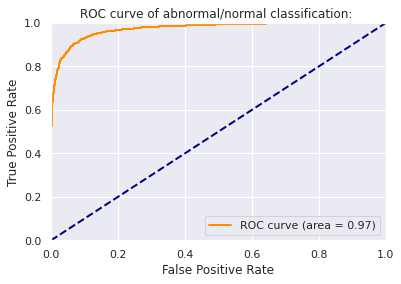

In [44]:
fpr_model,tpr_model=test(model,dataloaders['test'])

2022-01-22 03:45:45.576079


              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      1403
         1.0       0.94      0.65      0.77       597

    accuracy                           0.88      2000
   macro avg       0.90      0.82      0.85      2000
weighted avg       0.89      0.88      0.88      2000

Test Accuracy: 0.8830  Test AUC: 0.9497  Test_AP: 0.9195
TP: 388  FP: 25  TN: 1378  FN: 209
Sensitivity: 0.6499  Specificity: 0.9822
Precision: 93.95%  Recall: 64.99%  F1: 0.7683
PPV: 0.9395  NPV: 0.8683


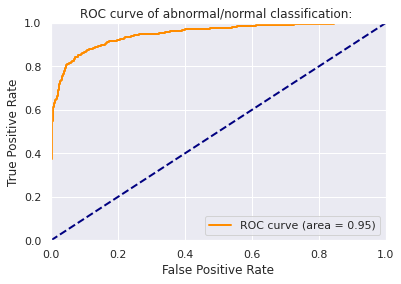

In [79]:
fpr_model,tpr_model=test(model,dataloaders['test'])

In [77]:
for i in range(df.shape[0]):
    if(df['path'][i]=='b7dab1e641e165ce08786d35a228b6c9.png'):
        print('yes',i)
        break

yes 13396


In [ ]:
from PIL import image
im=image.show('/b7dab1e641e165ce08786d35a228b6c9.png')

In [74]:
df.head()

,Unnamed: 0,path,target
14786,14786,f0805a178fb1901f23513be7b5262f5e.png,0
1222,1222,bdd7f0b920e6c5ea82526986ffb63001.png,1
13922,13922,2e25acfdadacf79ee609afed1b13a750.png,0
13045,13045,fae0a817c65ac6e549e94ac021544c22.png,0
1316,1316,4b514fdcb1c194983b7b34c9fc3e0ad5.png,0


2021-12-31 06:18:03.556675


              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       677
         1.0       0.94      0.88      0.91       667

    accuracy                           0.91      1344
   macro avg       0.92      0.91      0.91      1344
weighted avg       0.92      0.91      0.91      1344

Test Accuracy: 0.9144  Test AUC: 0.9690  Test_AP: 0.9743
TP: 589  FP: 37  TN: 640  FN: 78
Sensitivity: 0.8831  Specificity: 0.9453
Precision: 94.09%  Recall: 88.31%  F1: 0.9111
PPV: 0.9409  NPV: 0.8914


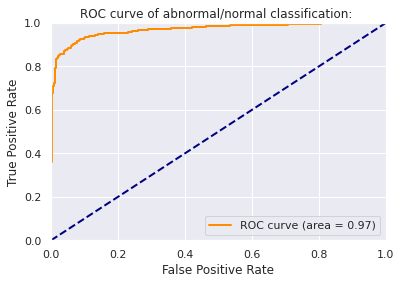

In [68]:
fpr_model,tpr_model=test(base_model,dataloaders['test'])

In [11]:
# print("\nVINBIG wow")
# df_vbwow=pd.read_csv("/DATA/dataset/vinbig/vinbig/vinbigall_main_19k.csv")
# df_vbwow=df_vbwow.sample(frac=1,random_state=172)
# print(df_vbwow["target"].value_counts())
# tr=int(0.6 * df_vbwow.shape[0])
# va=int(0.25*df_vbwow.shape[0])+tr
# # 0.60, 0.25,0.15
# img_dir='/DATA/dataset/vinbig/vinbig/'
# test_data=CustomImageDataset(df_vbwow,img_dir,transformations['test'],va,df_vbwow.shape[0])
# print(len(test_data))
# testloader_vbwow=torch.utils.data.DataLoader(test_data, batch_size=64)
# print(len(testloader_vbwow))

# # df_vbwow=pd.DataFrame()


VINBIG wow
1.0    10985
0.0    10606
Name: target, dtype: int64
3240
51


In [20]:
# pths=['/DATA/chowdari1/saved_models/vinbig_gold_21k(100epoch).pth']

In [ ]:
# model=densenet_Model(pretrained=True)   
# x_model=torch.load(pths[0],map_location='cpu')
# # x_model=x_model.to(device)
# model.load_state_dict(x_model)
# model=model.to(device)
# model.eval()

In [13]:
# df_vbwow.shape

(21591, 3)

In [21]:
# testdf=pd.DataFrame()
# size=len(pths)
# testdf['path']=np.empty(size)
# testdf['accu']=np.empty(size)
# testdf['auc']=np.empty(size)

In [22]:
# testdf

,path,accu,auc
0,0.0,0.0,0.0


In [29]:
# import datetime
# now = datetime. datetime. now()
# from sklearn import metrics
# def test(model,dataloader):
#     print (datetime. datetime. now())
#     model.eval()
#     running_corrects = 0
#     output_list =[]
#     label_list = []
#     preds_list = []
#     phase='test'
#     with torch.no_grad():
#         for inputs, labels in tqdm.tqdm(dataloader, leave=False):
#             labels_auc = labels
#             labels_print = labels
#             labels_auc = labels_auc.type(torch.FloatTensor)
#             labels = labels.type(torch.LongTensor) #add for BCE loss
#             inputs = inputs.cuda(gpu_id, non_blocking=True)
#             labels = labels.cuda(gpu_id, non_blocking=True)
#             labels_auc = labels_auc.cuda(gpu_id, non_blocking=True)

#             labels = labels.view(labels.size()[0],-1) #add for BCE loss
#             labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
#             # forward
#             outputs = model(inputs)
#             # _, preds = torch.max(outputs.data, 1)
#             score = torch.sigmoid(outputs)
#             score_np = score.data.cpu().numpy()
#             preds = score>0.5
#             preds_np = preds.data.cpu().numpy()
#             preds = preds.type(torch.cuda.LongTensor)

#             labels_auc = labels_auc.data.cpu().numpy()
#             outputs = outputs.data.cpu().numpy()
#             for i in range(outputs.shape[0]):
#                 output_list.append(outputs[i].tolist())
#                 label_list.append(labels_auc[i].tolist())
#                 preds_list.append(preds_np[i].tolist())
#             # running_corrects += torch.sum(preds == labels.data)
#             # labels = labels.type(torch.cuda.FloatTensor)
#             running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss
#     data_size=len(dataloader.sampler)
#     acc = np.float(running_corrects) / data_size
#     auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)
#     # print(auc)
#     fpr, tpr, _ = metrics.roc_curve(np.array(label_list), np.array(output_list))
#     roc_auc = metrics.auc(fpr, tpr)

#     ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))

#     tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

#     recall = tp/(tp+fn)
#     precision = tp/(tp+fp)
#     f1 = 2*precision*recall/(precision+recall)
#     sensitivity = recall
#     specificity = tn/(tn+fp)
#     PPV = tp/(tp+fp)
#     NPV = tn/(tn+fn)

#     print(classification_report(label_list,preds_list))
#     print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
#     print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
#     print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
#     print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
#     print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))
#     # Plot all ROC curves
#     plt.figure()
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC curve of abnormal/normal classification: ')
#     plt.legend(loc="lower right")
#     # plt.savefig('ROC_abnormal_normal_cls_'+args.arch+'_'+args.test_labels+'.pdf', bbox_inches='tight')
#     plt.show()
#     # return fpr,tpr
#     return round(auc,3),round(acc,3)

In [31]:
# testdf

,path,accu,auc
0,/DATA/chowdari1/saved_models/vinbig_gold_21k(1...,0.954,0.992


In [32]:
# dir='/DATA/chowdari1/test/test_final_models.csv'
# testdf.to_csv(dir)

In [28]:
# c=round(testdf['auc'][0],3)
# c

0.992

2022-02-15 23:16:33.870198


              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1623
         1.0       0.97      0.93      0.95      1617

    accuracy                           0.95      3240
   macro avg       0.95      0.95      0.95      3240
weighted avg       0.95      0.95      0.95      3240

Test Accuracy: 0.9537  Test AUC: 0.9916  Test_AP: 0.9916
TP: 1511  FP: 44  TN: 1579  FN: 106
Sensitivity: 0.9344  Specificity: 0.9729
Precision: 97.17%  Recall: 93.44%  F1: 0.9527
PPV: 0.9717  NPV: 0.9371


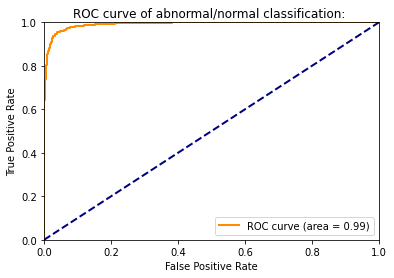

In [30]:
# testdf['auc'][0],testdf['accu'][0]=test(model,testloader_vbwow)
# testdf['path'][0]=pths[0]



In [73]:
!nvidia-smi

Sat Jan 22 03:40:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 47%   77C    P2   142W / 250W |   2471MiB / 11178MiB |     58%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 39%   72C    P2   192W / 250W |   9883MiB / 11178MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G